In [1364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer

In [1365]:
data = pd.read_csv("train.csv")

In [1366]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1367]:
def is_numeric_column(column):
    try:
        pd.to_numeric(column, errors='raise')
        return True
    except ValueError:
        return False
def prepare_data_auto(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())
    data.drop(['Alley'], axis=1,inplace=True)
    data.drop(['FireplaceQu'], axis=1,inplace=True)
    data.drop(['PoolQC'], axis=1,inplace=True)
    data.drop(['Fence'], axis=1,inplace=True)
    data.drop(['MiscFeature'], axis=1,inplace=True)
    data_map={}
    for column in data.columns:
        if data[column].isnull().sum()>0:
            data[column] = data[column].fillna(data[column].mode()[0])
        if not is_numeric_column(data[column]):
            unique_values=data[column].unique().tolist()
            unique_values.sort()
            values_dict={}
            index=0
            for i in unique_values:
                values_dict[i]=index
                index+=1
            data[column]=data[column].map(values_dict)
            data_map[column]=values_dict
        elif column!='SalePrice':
            max_value = data[column].max()
            data[column] = data[column]/max_value
    return data_map
def prepare_data_test(data,data_map):
    data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())
    data.drop(['Alley'], axis=1,inplace=True)
    data.drop(['FireplaceQu'], axis=1,inplace=True)
    data.drop(['PoolQC'], axis=1,inplace=True)
    data.drop(['Fence'], axis=1,inplace=True)
    data.drop(['MiscFeature'], axis=1,inplace=True)
    for column in data.columns:
        if data[column].isnull().sum()>0:
            data[column] = data[column].fillna(data[column].mode()[0])
        if not is_numeric_column(data[column]):
            values_dict=data_map[column] 
            data[column]=data[column].map(values_dict)
        elif column!='SalePrice':
            max_value = data[column].max()
            data[column] = data[column]/max_value
def prepare_data_new(data):
    data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontage'].mean())
    data.drop(['Alley'], axis=1,inplace=True)
    data.drop(['FireplaceQu'], axis=1,inplace=True)
    data.drop(['PoolQC'], axis=1,inplace=True)
    data.drop(['Fence'], axis=1,inplace=True)
    data.drop(['MiscFeature'], axis=1,inplace=True)
    for column in data.columns:
        if data[column].isnull().sum()>0:
            data[column] = data[column].fillna(data[column].mode()[0])
        data_column = data[[column]].values
        if not is_numeric_column(data[column]):
            label = LabelEncoder()
            label.fit(data[column])
            data[column]=label.transform(data[column])
        elif column!='SalePrice':
            scaler = StandardScaler()
            data_column =  scaler.fit_transform(data_column)
            #normalizer = Normalizer()
            #data_column = normalizer.fit_transform(data_column)
            data[column] = data_column
            
def plot_standart(real,pred):
    plt.plot(real, label='Real')
    plt.plot(pred, label='Prediction')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Real vs Prediction')
    plt.show()
    
def plot_sorted(real,pred):
    real_sorted=sorted(real)
    pred_sorted=sorted(pred)
    plt.plot(real_sorted, label='Real')
    plt.plot(pred_sorted, label='Prediction')
    plt.legend()
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Real vs Prediction')
    plt.show()
    
def hist_prediction(real,pred):
    bin_count=100
    plt.hist(pred, bins=bin_count, edgecolor='black')
    plt.hist(real, bins=bin_count, edgecolor='black')
    plt.xlabel('Index')
    plt.ylabel('Count')
    plt.title('Распределение')
    print(np.mean(prediction)-np.mean(test_target))

In [1368]:
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

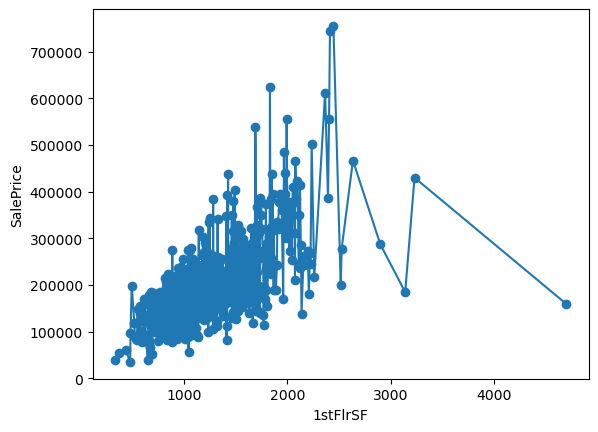

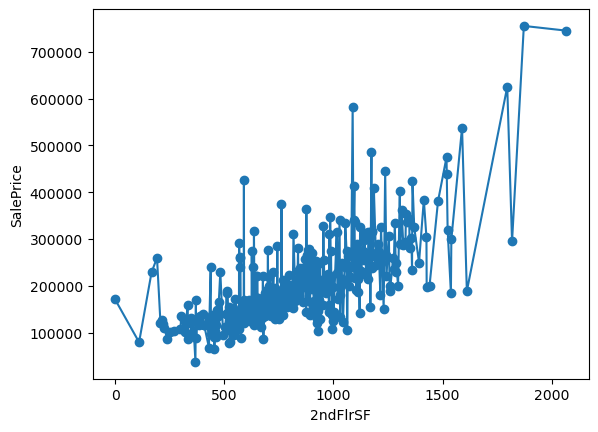

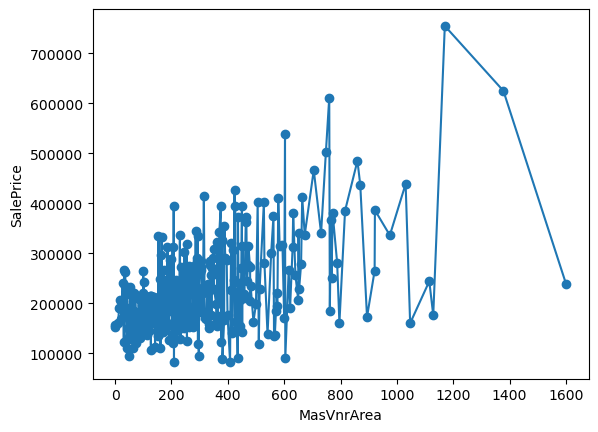

In [1369]:
params = ['1stFlrSF','2ndFlrSF','MasVnrArea']
for param in params:
    class_price = data.groupby(param)[['SalePrice']].mean()
    param_values = class_price.index.values
    saleprice_values = class_price['SalePrice'].values
    plt.plot(param_values, saleprice_values, 'o-')
    
    # Добавьте название осей
    plt.xlabel(param)
    plt.ylabel('SalePrice')
    
    # Показатьграфик
    plt.show()

In [1370]:
#data_map = prepare_data_auto(data)
prepare_data_new(data)
data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 76, dtype: int64

In [1371]:
data.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-1.730865,0.073375,3,-2.293718e-01,-0.207142,1,3,3,0,4,...,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,8,4,208500
1,-1.728492,-0.872563,3,4.519361e-01,-0.091886,1,3,3,0,2,...,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,8,4,181500
2,-1.726120,0.073375,3,-9.311018e-02,0.073480,1,0,3,0,4,...,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,8,4,223500
3,-1.723747,0.309859,3,-4.564744e-01,-0.096897,1,0,3,0,0,...,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,8,0,140000
4,-1.721374,0.073375,3,6.336182e-01,0.375148,1,0,3,0,2,...,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,8,4,250000
5,-1.719002,-0.163109,3,6.790387e-01,0.360616,1,0,3,0,4,...,-0.359325,10.802446,-0.270208,-0.068692,1.323736,1.360892,0.891994,8,4,143000
6,-1.716629,-0.872563,3,2.248335e-01,-0.043379,1,3,3,0,4,...,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,8,4,307000
7,-1.714256,0.073375,3,6.454645e-16,-0.013513,1,0,3,0,0,...,3.372372,-0.116339,-0.270208,-0.068692,0.618024,1.730892,0.891994,8,4,200000
8,-1.711883,-0.163109,4,-8.652591e-01,-0.440659,1,3,3,0,4,...,2.995929,-0.116339,-0.270208,-0.068692,-0.087688,-0.859110,0.138777,8,0,129900
9,-1.709511,3.147673,3,-9.106796e-01,-0.310370,1,3,3,0,0,...,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.969111,0.138777,8,4,118000


Text(0.5, 1.0, 'Распределение SalePrice')

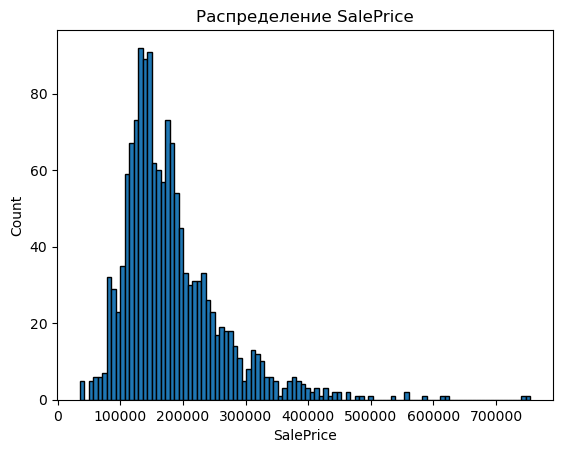

In [1372]:
plt.hist(data['SalePrice'], bins=100, edgecolor='black')

# Добавьте название осей
plt.xlabel('SalePrice')
plt.ylabel('Count')

# Добавьте заголовок графика
plt.title('Распределение SalePrice')

In [1373]:
train_target = data['SalePrice']
drop_params = ['Id']
#drop_params = data.drop(['OverallQual','OverallCond', 'SalePrice','ExterQual', 'ExterCond','SaleCondition','SaleType','BsmtQual','BsmtCond','1stFlrSF','2ndFlrSF','MasVnrArea','LotArea'], axis=1)
train_data = data.drop(drop_params, axis=1)
train_data = train_data.drop('SalePrice', axis=1)

In [1374]:
#model = LGBMRegressor(random_state=10, objective='mae', learning_rate=0.247332, n_estimators=300, num_leaves=30, max_depth=12, feature_fraction = 0.89952, min_data_in_leaf = 10)
model=RandomForestRegressor(max_depth=None,min_samples_split=2, n_estimators=200)

In [1375]:
param_grid = {
    'n_estimators': [50, 100, 200],  # число деревьев
    'max_depth': [None, 5, 10],      # максимальная глубина деревьев
    'min_samples_split': [2, 5, 10]  # минимальное число объектов для разделения узла
}

grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)

In [1376]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_target, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
test_pred = model.predict(X_test)
metric = metrics.mean_absolute_percentage_error(y_test, test_pred)
metric

0.10741304871745373

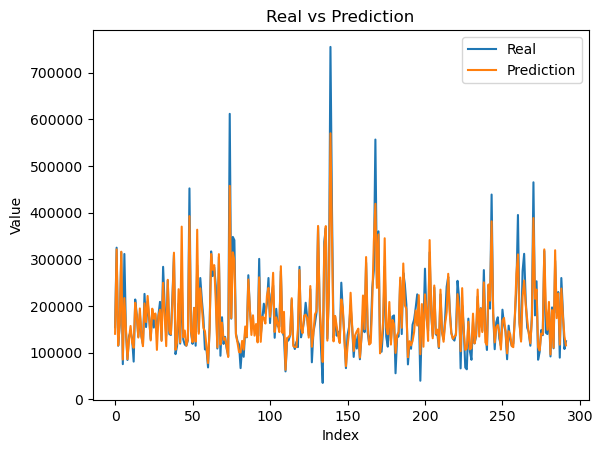

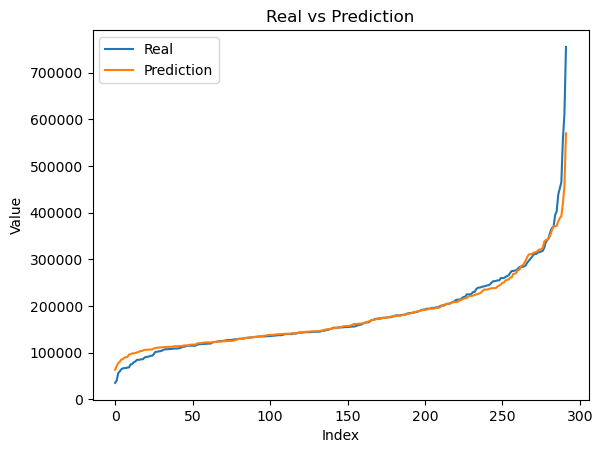

2093.8715385877003


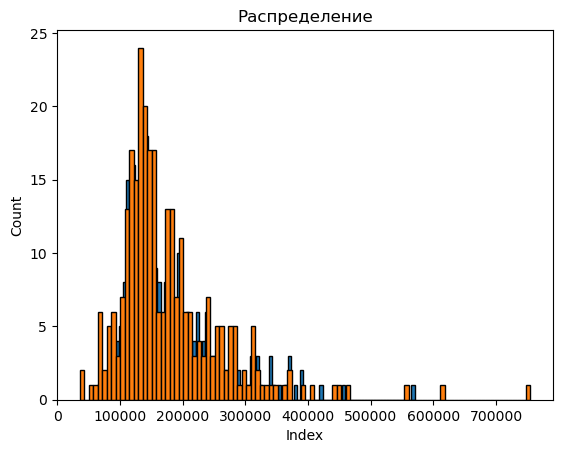

In [1377]:
plot_standart(y_test.to_list(),test_pred)
plot_sorted(y_test,test_pred)
hist_prediction(y_test,test_pred)

In [1378]:
model.fit(train_data, train_target)
#grid_search.fit(train_data, train_target)

RandomForestRegressor(n_estimators=200)

In [1379]:
#print("Лучшие параметры: ", grid_search.best_params_)
#print("Лучшее MSE: ", -grid_search.best_score_)

In [1380]:
test_data = pd.read_csv("test.csv")
test_target = pd.read_csv("sample_submission.csv")

In [1381]:
#prepare_data_test(test_data,data_map)
prepare_data_new(test_data)
test_data.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-1.730864,-0.874711,2,0.555587,0.363929,1,3,3,0,4,...,-0.701628,-0.360738,-0.088827,1.818960,-0.057227,-0.092244,-0.038281,1.713905,8,4
1,-1.728490,-0.874711,3,0.604239,0.897861,1,0,3,0,0,...,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,19.730438,-0.038281,1.713905,8,4
2,-1.726115,0.061351,3,0.263676,0.809646,1,0,3,0,4,...,-0.207871,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-1.140614,1.713905,8,4
3,-1.723741,0.061351,3,0.458284,0.032064,1,0,3,0,4,...,-0.178826,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.038281,1.713905,8,4
4,-1.721367,1.465443,3,-1.244533,-0.971808,1,0,1,0,4,...,0.489198,-0.360738,-0.088827,2.243060,-0.057227,-0.092244,-1.875504,1.713905,8,4
5,-1.718993,0.061351,3,0.312328,0.036505,1,0,3,0,0,...,0.518243,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.773170,1.713905,8,4
6,-1.716618,-0.874711,3,0.000000,-0.371261,1,0,3,0,4,...,-0.396660,-0.360738,-0.088827,-0.301543,-0.057227,0.700664,-1.140614,1.713905,8,4
7,-1.714244,0.061351,3,-0.271495,-0.286074,1,0,3,0,4,...,0.387543,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.405725,1.713905,8,4
8,-1.711870,-0.874711,3,0.798847,0.072033,1,3,3,0,4,...,-0.701628,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-1.508059,1.713905,8,4
9,-1.709495,-0.874711,3,0.069068,-0.286478,1,3,3,0,0,...,-0.701628,-0.360738,-0.088827,-0.301543,-0.057227,-0.092244,-0.773170,1.713905,8,4


In [1382]:
test_data=test_data.drop(drop_params, axis=1)
test_target=test_target['SalePrice']

In [1383]:
def close_to_mean(prediction):
    for i in range(0,len(prediction)):
        if prediction[i]>mean_pred*1.5:
            prediction[i]=prediction[i]*0.7
        elif prediction[i]<mean_pred*0.7:
            prediction[i]=prediction[i]*1.5

prediction = model.predict(test_data)
mean_pred=np.mean(prediction)
#close_to_mean(prediction)
for i in range(0,30):
    print(prediction[i])

127033.37
156934.32
182662.1
181607.725
196168.74
185238.085
169385.635
176510.25
179688.07
118557.545
193676.67
95255.5
95914.715
154561.25
141988.65
396702.02
256725.675
312836.665
253294.75
476071.065
320923.665
207931.695
178246.59
174278.52
172216.215
206878.7
335375.28
242651.145
212399.805
203118.97


In [1384]:
metric = metrics.mean_absolute_percentage_error(test_target, prediction)
metric

0.3033160625403218

In [1385]:
diviation = []
for i in range(0,len(prediction)):
    diviation.append(abs(prediction[i]-test_target[i]))
mean_div = sum(diviation)/len(diviation)
print(mean_div)

54447.3630177851


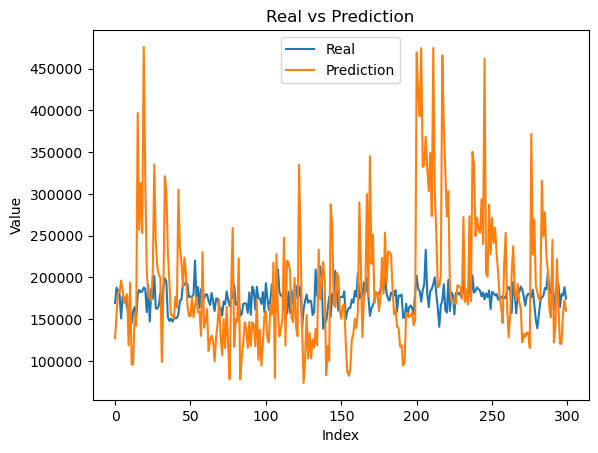

In [1386]:
plot_standart(test_target[0:300],prediction[0:300])

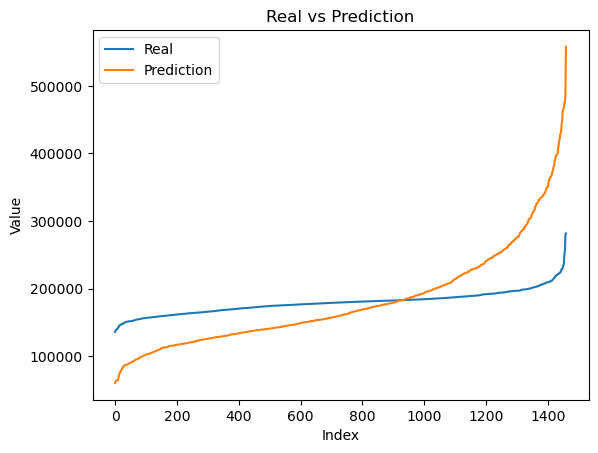

In [1387]:
plot_sorted(test_target,prediction)

2168.6372131290846


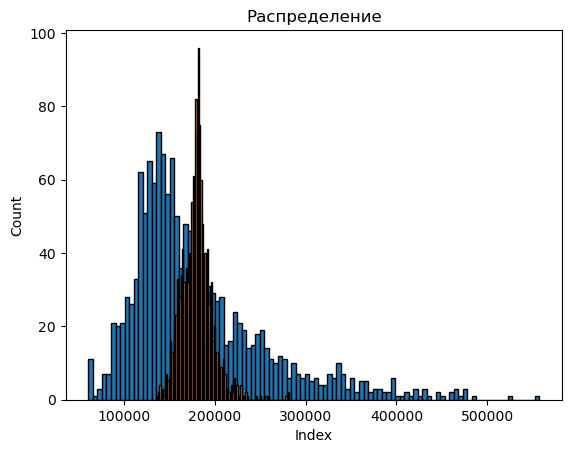

In [1388]:
hist_prediction(test_target,prediction)